In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy import stats
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (7,695 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 144676 files and d

In [3]:
#한글폰트 지정
plt.rc('font', family='NanumBarunGothic') 

In [4]:
total = pd.read_excel('/content/drive/My Drive/빅콘폴더/2020_bigcontest_champion_performance.xlsx', header=1)
total = total[total['상품군']!='무형'] 
total = total[total['판매단가'] < total['취급액']]
total['날짜'] = pd.to_datetime(total['방송일시']).dt.date
total['날짜'] = pd.to_datetime(total['날짜'])
total['주문량'] = total['취급액']/total['판매단가']
total["요일"]=total["방송일시"].dt.dayofweek # 요일
total["시"]=total["방송일시"].dt.hour # 시
total['월'] = total['방송일시'].dt.month # 월

In [5]:
total = total.fillna(method='ffill')

In [6]:
total = total[total['취급액']!=50000]
total.reindex(range(len(total)))

방송일시  노출(분)      마더코드  ...   요일     시     월
0     2019-01-01 06:00:00   20.0  100346.0  ...  1.0   6.0   1.0
1     2019-01-01 06:00:00   20.0  100346.0  ...  1.0   6.0   1.0
2     2019-01-01 06:20:00   20.0  100346.0  ...  1.0   6.0   1.0
3     2019-01-01 06:20:00   20.0  100346.0  ...  1.0   6.0   1.0
4     2019-01-01 06:40:00   20.0  100346.0  ...  1.0   6.0   1.0
...                   ...    ...       ...  ...  ...   ...   ...
35374 2019-12-10 10:40:00   20.0  100129.0  ...  1.0  10.0  12.0
35375 2019-12-10 10:40:00   20.0  100129.0  ...  1.0  10.0  12.0
35376 2019-12-10 11:00:00   20.0  100129.0  ...  1.0  11.0  12.0
35377 2019-12-10 11:00:00   20.0  100129.0  ...  1.0  11.0  12.0
35378 2019-12-10 11:20:00   20.0  100498.0  ...  1.0  11.0  12.0

[35379 rows x 13 columns]

In [7]:
total['상품군'].unique()

array(['의류', '속옷', '주방', '농수축', '이미용', '가전', '생활용품', '건강기능', '잡화', '가구',
       '침구'], dtype=object)

# 데이터 생성

In [8]:
train = pd.read_excel('/content/drive/My Drive/빅콘폴더/최종 데이터셋 후보/train.xlsx')
train = train[train['판매단가'] < train['취급액']]

In [9]:
train['노출(분)'] = train['노출(분)'].replace(0, math.nan)
train['노출(분)'] = train['노출(분)'].fillna(method='ffill')

In [10]:
train.index = np.arange(7513)

In [11]:
test = pd.read_excel('/content/drive/My Drive/빅콘폴더/test.xlsx', header=1)

In [12]:
data = pd.read_excel('/content/drive/My Drive/빅콘폴더/2020_bigcontest_champion_performance.xlsx', header=1)
data = data[data['상품군']!='무형'] 
data = data[data['판매단가'] < data['취급액']]
data['날짜'] = pd.to_datetime(data['방송일시']).dt.date
data['날짜'] = pd.to_datetime(data['날짜'])
data['주문량'] = data['취급액']/data['판매단가']
data["요일"]=data["방송일시"].dt.dayofweek # 요일
data["시"]=data["방송일시"].dt.hour # 시
data['월'] = data['방송일시'].dt.month # 월
weekday = {"월":0,"화":1,"수":2,"목":3,"금":4,"토":5,"일":6}

In [13]:
data = data.fillna(method='ffill')

In [14]:
data = data.iloc[17604:25792]

# 날씨 처리

In [15]:
# 대표 지역들
places = ["강릉","광주","부산","수원","울산","대구","대전","서울","파주"] 
weather = pd.read_excel("/content/drive/My Drive/빅콘폴더/날씨_실제/강릉날씨.xlsx")
row_num = weather.shape[0]
weather["지역"]=["강릉"]*row_num

In [16]:
# 모든 지역 날씨 데이터 세로로 합치기
for p in places[1:]:
    a=pd.read_excel(f"/content/drive/My Drive/빅콘폴더/날씨_실제/{p}날씨.xlsx")
    a["지역"]=[p]*row_num
    weather = pd.concat([weather, a], axis=0)

In [17]:
# "-" -> 0값으로 변경
weather["강수량(mm)"]=weather["강수량(mm)"].replace("-",0)
weather["신적설(cm)"]=weather["신적설(cm)"].replace("-",0)
weather["운량(1/10)"]=weather["운량(1/10)"].replace("-",0)

# object 형 float 형으로 변경
weather["강수량(mm)"]=weather["강수량(mm)"].astype(float)
weather["신적설(cm)"]=weather["신적설(cm)"].astype(float)
weather["운량(1/10)"]=weather["운량(1/10)"].astype(float)

In [18]:
weather = weather.reset_index()

In [19]:
# 날짜 set 맞추기
new_weather = pd.DataFrame()
new_weather = weather.iloc[165:243]
new_weather = pd.concat([new_weather, weather.iloc[753:831]])
new_weather = pd.concat([new_weather, weather.iloc[1341:1419]])
new_weather = pd.concat([new_weather, weather.iloc[1929:2007]])
new_weather = pd.concat([new_weather, weather.iloc[2517:2595]])
new_weather = pd.concat([new_weather, weather.iloc[3105:3183]])
new_weather = pd.concat([new_weather, weather.iloc[3693:3771]])
new_weather = pd.concat([new_weather, weather.iloc[4281:4359]])
new_weather = pd.concat([new_weather, weather.iloc[4869:4947]])

In [20]:
# 서울 날씨와 강릉, 부산 날씨로 칼럼별 주문량 상관성 확인 및 지역별 날씨의 영향도 확인
gang_weather = new_weather.loc[new_weather["지역"]=="강릉",:]
seoul_weather = new_weather.loc[new_weather["지역"]=="서울",:]
busan_weather = new_weather.loc[new_weather["지역"]=="부산",:]
suwon_weather = new_weather.loc[new_weather["지역"]=="수원",:]
sudogwon_weather = new_weather.loc[(new_weather["지역"]=="서울")|(weather["지역"]=="수원"),:]

In [21]:
day_data = data.copy()

In [22]:
day_data['날짜'] = pd.to_datetime(day_data['날짜'])
new_weather['날짜'] = pd.to_datetime(new_weather['날짜'])

In [23]:
all_data = day_data.merge(new_weather, on='날짜')
all_data = all_data.groupby(['날짜']).mean()

In [24]:
sudogwon_weather['날짜'] = pd.to_datetime(sudogwon_weather['날짜'] )
seoul_weather['날짜'] = pd.to_datetime(seoul_weather['날짜'] )
busan_weather['날짜'] =pd.to_datetime(busan_weather['날짜'] )
suwon_weather['날짜'] = pd.to_datetime(suwon_weather['날짜'] )
gang_weather['날짜'] = pd.to_datetime(gang_weather['날짜'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [25]:
sudogwon_data = day_data.merge(sudogwon_weather, on="날짜")
suwon_data = day_data.merge(suwon_weather, on="날짜")
seoul_data = day_data.merge(seoul_weather, on="날짜")
busan_data = day_data.merge(busan_weather, on="날짜")
gang_data = day_data.merge(gang_weather, on="날짜")

In [26]:
fc_prop = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/강수확률.csv")
fc_amount = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/6시간 강수량.csv") 
fc_sky = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/하늘상태.csv")
fc_top = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/일최고기온.csv")
fc_bottom = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/일최저기온.csv")

In [27]:
forecast_data = {"강수확률":fc_prop, "강수량":fc_amount,"하늘상태":fc_sky, "일최고기온":fc_top, "일최저기온":fc_bottom}

In [28]:
forecast = pd.DataFrame()

for name, fcdata in forecast_data.items():
    amount_list=[]
    cycle = (fcdata.shape[0])//365 # 하루 관측량
    for i in range(365):
        day_weather = fcdata.iloc[i*cycle:(i+1)*cycle,-1].mean()
        amount_list.append(day_weather)
    forecast[name]=amount_list

In [29]:
forecast = forecast.iloc[165:243]

In [30]:
# 날짜 칼럼 추가
forecast["날짜"]=train["날짜"].unique()

# 마더코드, 일/월별 처리

In [31]:
def hand_by_momcode(data):
  momcodegroup = data.groupby(['마더코드']).sum()
  momcodegroup['주문량/노출'] = momcodegroup['주문량']/momcodegroup['노출(분)']
  topcode = list(momcodegroup.sort_values('주문량/노출', ascending=False).index[:50]) #탑50개
  return topcode

In [32]:
hand_by_momcode(train) # train으로 topcode생성

[100492,
 100499,
 100046,
 100754,
 100323,
 100253,
 100844,
 100523,
 100019,
 100167,
 100841,
 100452,
 100026,
 100829,
 100818,
 100777,
 100021,
 100322,
 100511,
 100416,
 100822,
 100172,
 100455,
 100348,
 100589,
 100166,
 100165,
 100074,
 100197,
 100403,
 100327,
 100281,
 100460,
 100015,
 100588,
 100169,
 100318,
 100755,
 100275,
 100010,
 100479,
 100202,
 100612,
 100009,
 100319,
 100773,
 100747,
 100171,
 100109,
 100849]

- 상품군내 마더코드별 주문량

In [33]:
multi_grouped = train.groupby(['상품군','마더코드'])
MultiGroup = multi_grouped['주문량'].sum()
MultiGroup = MultiGroup.reset_index()

In [34]:
item = list(set(MultiGroup['상품군']))

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45908 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_

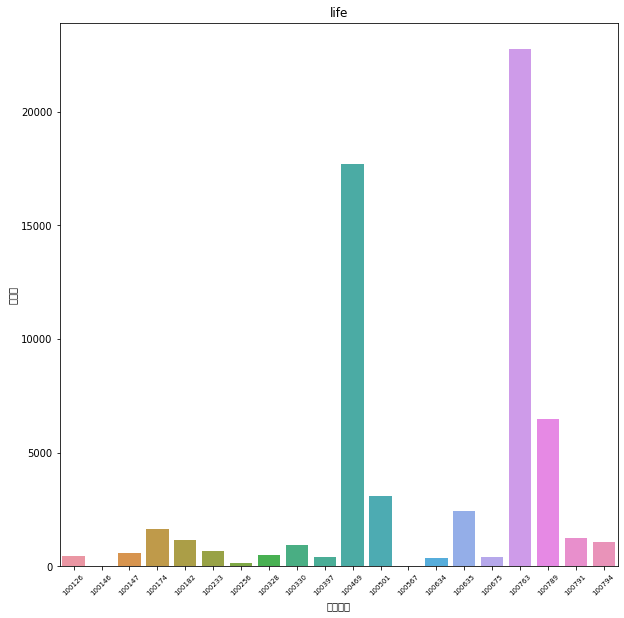

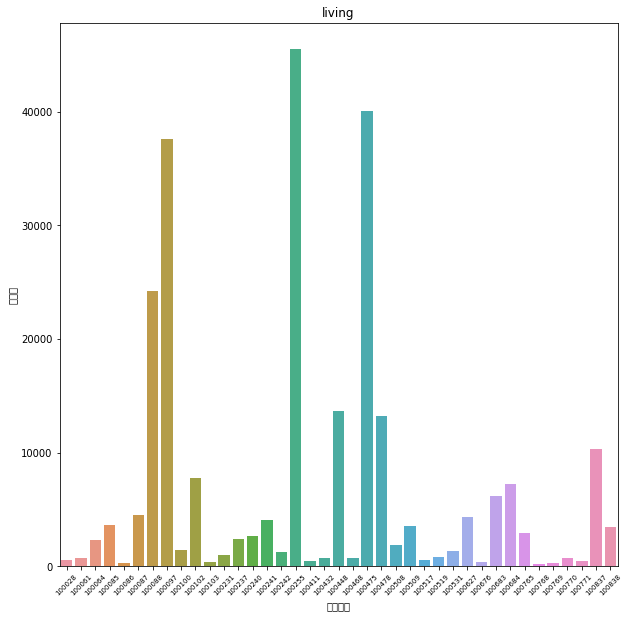

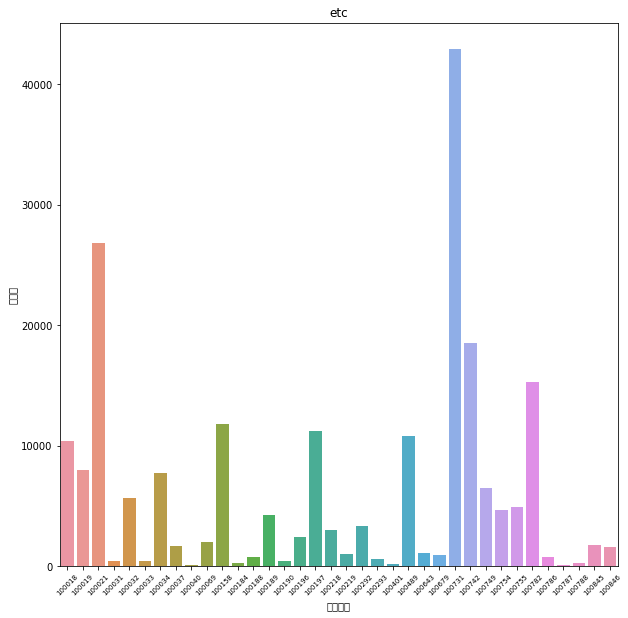

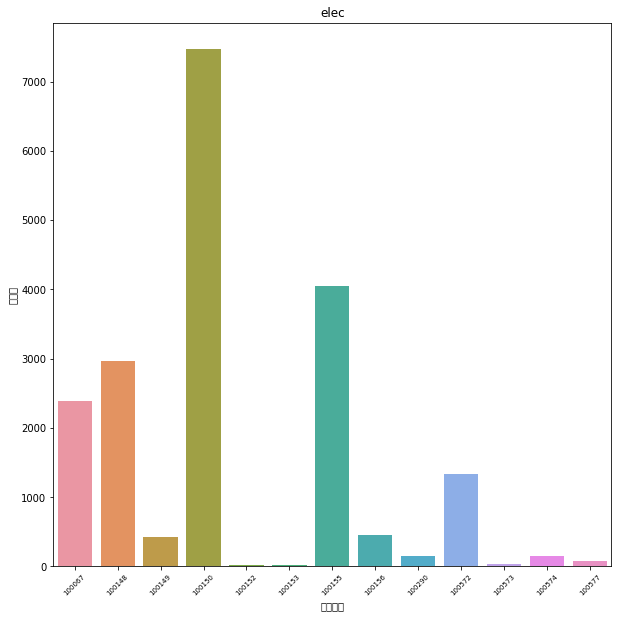

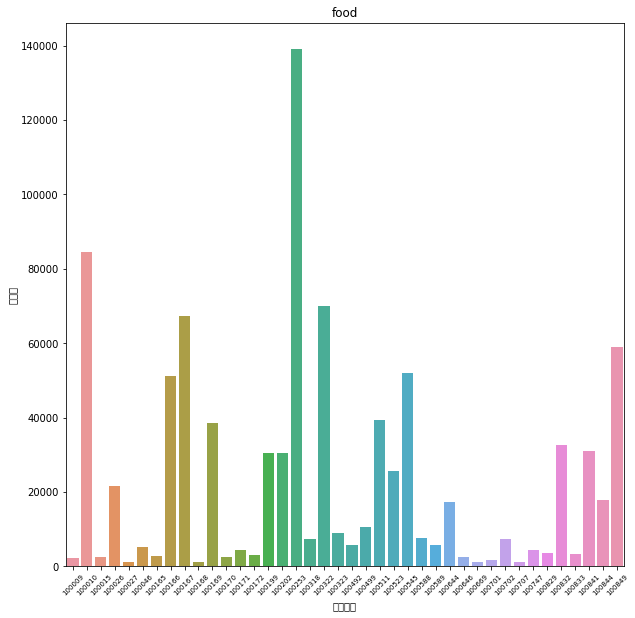

In [35]:
for i in item:
    plt.figure(figsize=(10,10))
    sns.barplot(data=MultiGroup[MultiGroup['상품군']==i], x='마더코드', y='주문량')
    plt.title(i)
    plt.xticks(rotation=45, size=7)

- 시간대 상품군별 주문량

In [36]:
hour_grouped = train.groupby(['시','상품군'])
HourGroup = hour_grouped['주문량'].sum()
HourGroup = HourGroup.reset_index()

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_te

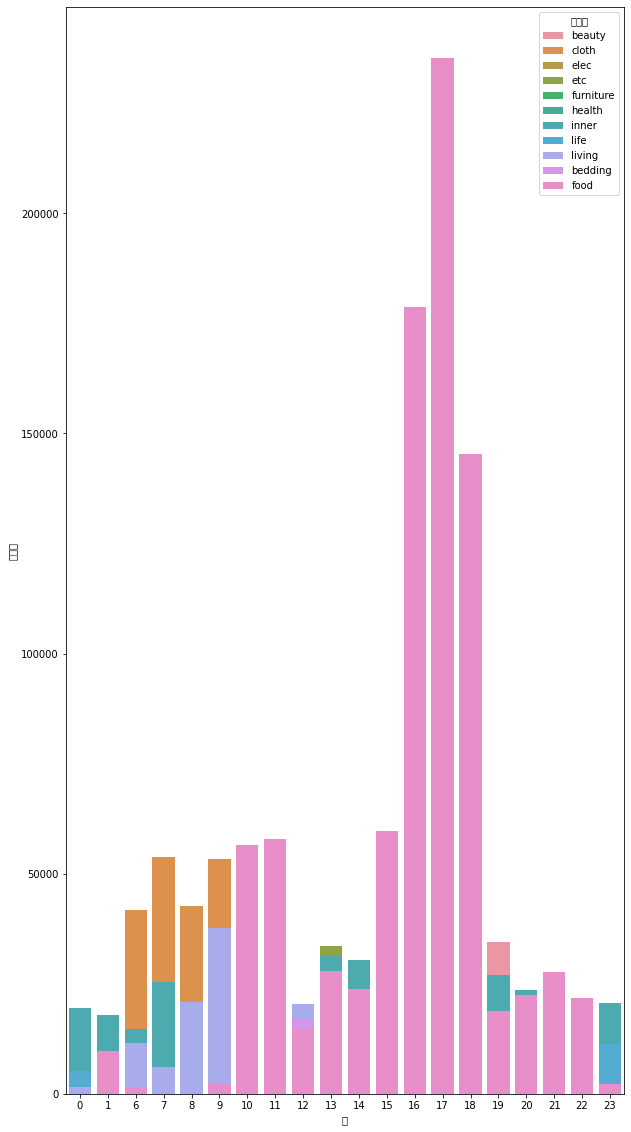

In [37]:
plt.figure(figsize=(10,20))
sns.barplot(data=HourGroup, x='시', y='주문량', hue='상품군', dodge=False)

In [38]:
train['new판매단가'] = np.log(train['판매단가'])
train.drop('판매단가', inplace=True, axis=1)

In [39]:
np.corrcoef(train['주문량'],train['new판매단가'])

array([[ 1.        , -0.61081947],
       [-0.61081947,  1.        ]])

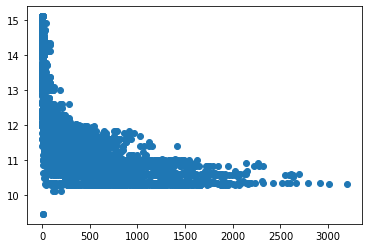

In [40]:
plt.scatter(train['주문량'], (train['new판매단가'])) 

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text

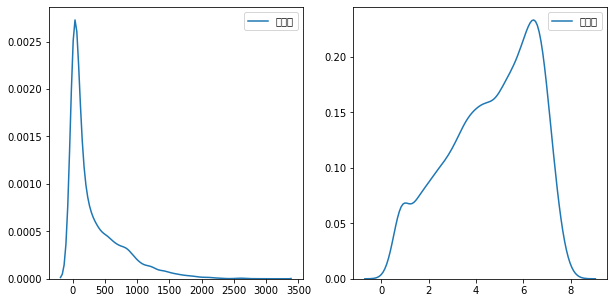

In [41]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.kdeplot(train['주문량'], ax=ax[0]) #커널 밀도추정
sns.kdeplot(np.log(train['주문량']), ax=ax[1])

In [42]:
train['new주문량'] = np.log(train['주문량'])
train.drop('주문량', inplace=True, axis=1)

# 모델학습 데이터 생성 및 분리

- 시간대

In [43]:
time = train.groupby('HOUR').aggregate(np.mean)

time_rank = {}
rank = 1 
for idx, row in time.sort_values(by='new주문량').iterrows():
    time_rank[idx] = rank
    rank += 1

In [44]:
prime_time = []

for idx, row in train.iterrows():
    prime_time.append(time_rank[row.HOUR])
    
train['prime_time'] = prime_time

- 요일

In [45]:
day = train.groupby('요일').aggregate(np.mean)

day_rank = {}
rank = 1 
for idx, row in day.sort_values(by='new주문량').iterrows():
    day_rank[idx] = rank
    rank += 1
    
prime_day = []

for idx, row in train.iterrows():
    prime_day.append(day_rank[row.요일])
    
train['prime_day'] = prime_day

- 요일

In [46]:
intercode = set(test['마더코드'].unique()).intersection(set(train['마더코드'].unique()))
interitem = train[train['마더코드'].isin(intercode)]

- test랑 겹치는 마더코드

In [47]:
code = interitem.groupby('마더코드').aggregate(np.mean)

code_rank = {}
rank = 1
for idx, row in code.sort_values(by='new주문량').iterrows():
    code_rank[idx] = rank
    rank += 1

top_code = []

for idx, row in train.iterrows():
    if row.마더코드 in code_rank.keys():
        top_code.append(code_rank[row.마더코드])
    else:
        top_code.append(0)
        
train['top_code'] = top_code

- 분류기준 top_분류

In [48]:
cat = train.groupby('분류').aggregate(np.mean)

cat_rank = {}
rank = 1
for idx, row in cat.sort_values(by='new주문량').iterrows():
    cat_rank[idx] = rank
    rank += 1

top_cat = []

for idx, row in train.iterrows():
    top_cat.append(cat_rank[row.분류])
    
train['top_cat'] = top_cat

- 성은님코드 : 분류원핫+pca
- 회선 : 빈도수인코딩

In [49]:
# 원핫+PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [50]:
enc1 = OneHotEncoder()
category = np.array(train['분류'])
category = category.reshape(-1, 1)

In [51]:
enc1.fit(category)
category_ = enc1.transform(category).toarray()

In [52]:
pca = PCA(n_components=2)
res = pca.fit_transform(category_)
res = pd.DataFrame(res, columns=['x1_cat','x2_cat'])

In [53]:
train['x1_cat'] = res['x1_cat']
train['x2_cat'] = res['x2_cat']

In [54]:
train['x1_cat']

0      -0.006708
1      -0.006708
2      -0.006708
3      -0.076896
4      -0.076896
          ...   
7508   -0.011995
7509   -0.005012
7510   -0.005012
7511   -0.005012
7512   -0.005012
Name: x1_cat, Length: 7513, dtype: float64

- 실제날씨(서울)

In [55]:
real = train.groupby('실제_서울_날씨').aggregate(np.mean)

real_rank = {}
rank = 1
for idx, row in real.sort_values(by='new주문량').iterrows():
    real_rank[idx] = rank
    rank += 1

top_real_weather = []

for idx, row in train.iterrows():
    top_real_weather.append(real_rank[row.실제_서울_날씨])
    
train['top_real_weather'] = top_real_weather

-실제날씨 통합

In [56]:
real_total_weather = pd.read_excel('/content/drive/My Drive/빅콘폴더/날씨_실제/날씨통합.xlsx')
real_total_weather

최고기온       최저기온  강수량      평균풍속
0     27.266667  16.766667  0.8  2.200000
1     27.266667  16.766667  0.8  2.200000
2     27.266667  16.766667  0.8  2.200000
3     27.266667  16.766667  0.8  2.200000
4     27.266667  16.766667  0.8  2.200000
...         ...        ...  ...       ...
7508  28.100000  17.133333  0.0  1.466667
7509  28.100000  17.133333  0.0  1.466667
7510  28.100000  17.133333  0.0  1.466667
7511  28.100000  17.133333  0.0  1.466667
7512  28.100000  17.133333  0.0  1.466667

[7513 rows x 4 columns]

In [57]:
train['실제_최고기온'] = real_total_weather['최고기온']
train['실제_최저기온'] = real_total_weather['최저기온']
train['실제_강수량'] = real_total_weather['강수량']
train['실제_평균풍속'] = real_total_weather['평균풍속']

In [58]:
train

Unnamed: 0                방송일시  노출(분)  ...    실제_최저기온  실제_강수량   실제_평균풍속
0          17373 2019-06-15 00:00:00   20.0  ...  16.766667     0.8  2.200000
1          17374 2019-06-15 00:20:00   20.0  ...  16.766667     0.8  2.200000
2          17375 2019-06-15 00:40:00   20.0  ...  16.766667     0.8  2.200000
3          17376 2019-06-15 01:00:00   30.0  ...  16.766667     0.8  2.200000
4          17377 2019-06-15 01:00:00   30.0  ...  16.766667     0.8  2.200000
...          ...                 ...    ...  ...        ...     ...       ...
7508       25398 2019-08-31 23:00:00   20.0  ...  17.133333     0.0  1.466667
7509       25399 2019-08-31 23:20:00   20.0  ...  17.133333     0.0  1.466667
7510       25400 2019-08-31 23:20:00   20.0  ...  17.133333     0.0  1.466667
7511       25401 2019-08-31 23:40:00   20.0  ...  17.133333     0.0  1.466667
7512       25402 2019-08-31 23:40:00   20.0  ...  17.133333     0.0  1.466667

[7513 rows x 69 columns]

In [59]:
#corr_mat = train.corr()
#corr_mat['new주문량'].sort_values(ascending=False)

In [60]:
# train.drop(['Unnamed: 0', '방송일시', '상품명', '상품군', 'holiday', '요일', 'HOUR', '마더코드'], inplace=True, axis=1)
# 방송일시, 상품명, 상품군, holiday(주말), 요일, HOUR, 마더코드

# Feature Engineering & 인코딩

In [61]:
# 빈도수인코딩(위의 원핫+pca와 비교해보기)
def add_frequency_encoding(data,column): #데이터프레임,열을 받아서 빈도수인코딩열을 추가해줌
  enc_nom = (data.groupby(column).size())/len(data)
  data['freq_encode_{}'.format(column)] = data[column].apply(lambda x:enc_nom[x])
  print("freq_encode column was added")

In [62]:
add_frequency_encoding(train,'분류')

freq_encode column was added


# 모델 생성 및 학습

- train, test split

In [63]:
'''
# 통째로 split할경우 실행

from sklearn.model_selection import train_test_split

total_x = train.drop('new주문량', axis=1)
total_y = train['new주문량']

total_x_train, total_x_val, total_y_train, total_y_val = train_test_split(x, y, test_size=0.33, random_state=1234)
'''

"\n# 통째로 split할경우 실행\n\nfrom sklearn.model_selection import train_test_split\n\ntotal_x = train.drop('new주문량', axis=1)\ntotal_y = train['new주문량']\n\ntotal_x_train, total_x_val, total_y_train, total_y_val = train_test_split(x, y, test_size=0.33, random_state=1234)\n"

In [64]:
#모든 카테고리에 대해 따로따로 자동 변수생성
category_list = train['상품군'].unique().tolist()
for i in category_list:
  globals()['x_{}'.format(i)] = train.loc[train['상품군']==i] #카테고리에 해당하는 주문량제외 train데이터 할당
  globals()['y_{}'.format(i)] = train['new주문량'].loc[train['상품군']==i] #카테고리에 해당하는 train의 주문량을 할당

In [65]:
for i in range(11):
  print('x_{}'.format(category_list[i])) #11개 상품군 다 성공적으로 변수 생성됨.

x_inner
x_cloth
x_elec
x_living
x_food
x_health
x_bedding
x_furniture
x_beauty
x_etc
x_life


In [66]:
#카테고리별로 x,y를 train test 스플릿해줌.
from sklearn.model_selection import train_test_split
for i in category_list:
  x_for_split = globals()['x_{}'.format(i)]
  y_for_split = globals()['y_{}'.format(i)]
  globals()['x_train_{}'.format(i)], globals()['x_test_{}'.format(i)], globals()['y_train_{}'.format(i)], globals()['y_test_{}'.format(i)] = train_test_split(x_for_split, y_for_split, test_size=0.33, random_state=1234)
# 카테고리별로 X_train_카테고리 , X_test_카테고리, Y_train_카테고리, Y_test_카테고리 생성됐음.

In [67]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=1234)

In [68]:
seungen_feature = ['노출(분)', 'holiday(includeSS)','실제_최고기온','실제_최저기온','실제_강수량','실제_평균풍속' , '예보_서울_강수확률', '예보_서울_강수량',
       '예보_서울_하늘상태', '예보_서울_일최고기온', '예보_서울_일최저기온', '예보_일산_강수확률', '예보_일산_강수량',
       '예보_일산_일최고기온', '예보_일산_일최저기온', '예보_수원_강수확률', '예보_수원_강수량', '예보_수원_일최고기온',
       '예보_수원_일최저기온', 'Active Users', 'new판매단가', 'prime_time',
       'prime_day', 'top_code', 'top_cat']

In [69]:
feature_selection = x_train_beauty.loc[:,seungen_feature].columns.values
feature_selection

array(['노출(분)', 'holiday(includeSS)', '실제_최고기온', '실제_최저기온', '실제_강수량',
       '실제_평균풍속', '예보_서울_강수확률', '예보_서울_강수량', '예보_서울_하늘상태', '예보_서울_일최고기온',
       '예보_서울_일최저기온', '예보_일산_강수확률', '예보_일산_강수량', '예보_일산_일최고기온',
       '예보_일산_일최저기온', '예보_수원_강수확률', '예보_수원_강수량', '예보_수원_일최고기온',
       '예보_수원_일최저기온', 'Active Users', 'new판매단가', 'prime_time',
       'prime_day', 'top_code', 'top_cat'], dtype=object)

In [70]:
for i in category_list:
  globals()['shop_train_x_{}'.format(i)] = globals()['x_train_{}'.format(i)][feature_selection]
  globals()['shop_test_x_{}'.format(i)] = globals()['x_test_{}'.format(i)][feature_selection]

# 6번. 카테고리별 20분단위로 3갈해서 각각 피팅


In [92]:
Imsi_list = x_beauty.groupby(['마더코드','날짜']).count()['노출(분)'] #마더코드별로 방송 노출분
Imsi_list

마더코드    날짜        
100000  2019-08-26    3
        2019-08-30    3
100074  2019-06-18    3
        2019-06-24    3
        2019-06-25    3
                     ..
100773  2019-07-06    3
        2019-07-15    3
        2019-07-19    3
        2019-07-26    3
        2019-07-29    3
Name: 노출(분), Length: 71, dtype: int64

In [108]:
len(x_beauty), len(Imsi_list) #beauty전체항목수, 마더코드/날짜 별로 묶인 그룹수

(216, 71)

In [72]:
hallo = train.groupby(['마더코드','날짜']).count()['노출(분)'] 
len(hallo[hallo==6]),len(hallo[hallo==5]),len(hallo[hallo==4]),len(hallo[hallo==3]),len(hallo[hallo==2]),len(hallo[hallo==1])

(279, 13, 29, 815, 89, 14)

In [221]:
for i in range(len(Imsi_list)):
  Imsi_df = x_beauty[(x_beauty['마더코드']==Imsi_list.index[i][0]) & (x_beauty['날짜']==Imsi_list.index[i][1])]
  globals()['x_beauty_group{}'.format(i)] = pd.DataFrame()
  count = 0
  for j in range(len(Imsi_df)):
    if(count< Imsi_list.iloc[i]): #각 마더코드/날짜별 (행의)출현횟수 넘지 않는것만 df에 추가.
      globals()['x_beauty_group{}'.format(i)] = globals()['x_beauty_group{}'.format(i)].append(Imsi_df.iloc[j])
      count+=1

In [222]:
print(x_beauty_group0,x_beauty_group1,x_beauty_group2,x_beauty_group70) # 분리 성공

      Active Users        DATE  DAY  ...  일산화탄소농도(ppm)  초미세먼지(㎍/㎥)         취급액
7013      153498.0  20190826.0  mon  ...       0.02048      0.0038  12078000.0
7014      153498.0  20190826.0  mon  ...       0.02048      0.0038  17338000.0
7015      153498.0  20190826.0  mon  ...       0.02048      0.0038  18195000.0

[3 rows x 70 columns]       Active Users        DATE  DAY  ...  일산화탄소농도(ppm)  초미세먼지(㎍/㎥)         취급액
7351      146126.0  20190830.0  fri  ...       0.01808      0.0036   5905000.0
7352      151192.0  20190830.0  fri  ...       0.01808      0.0036  11888000.0
7353      151192.0  20190830.0  fri  ...       0.01808      0.0036  11158000.0

[3 rows x 70 columns]      Active Users        DATE  DAY  ...  일산화탄소농도(ppm)  초미세먼지(㎍/㎥)         취급액
363      123763.0  20190618.0  tue  ...       0.02456     0.00384  24872000.0
364      123763.0  20190618.0  tue  ...       0.02456     0.00384  46448000.0
365      123763.0  20190618.0  tue  ...       0.02456     0.00384  73136000.0

[3 rows x

In [224]:
sum_hallo = 0
count = 0
for i in range(len(Imsi_list)):
  hallo = len(globals()['x_beauty_group{}'.format(i)])
  count+=1
  sum_hallo = sum_hallo+hallo
sum_hallo,count #정확히 216개 data모두 사용, 71개 그룹 만들어짐.

(216, 71)

- 그룹별로 3갈하기

In [256]:
Imsi_list2 = x_beauty.groupby(['마더코드','날짜']).max()['노출(분)'] 
Imsi_list2

마더코드    날짜        
100000  2019-08-26    20.0
        2019-08-30    20.0
100074  2019-06-18    20.0
        2019-06-24    20.0
        2019-06-25    20.0
                      ... 
100773  2019-07-06    20.0
        2019-07-15    20.0
        2019-07-19    20.0
        2019-07-26    20.0
        2019-07-29    20.0
Name: 노출(분), Length: 71, dtype: float64

In [86]:
beauty_momcode = x_beauty['마더코드'].unique()
print(beauty_momcode)

[100628 100399 100074 100773 100319 100766 100213 100244 100000 100332
 100327]


In [89]:
pd.Timedelta('0 days 00:{}:00'.format(int(Imsi_list2.loc[100773][0]))) #방송 노출(분)을 기준시간으로 잡겠다.

Timedelta('0 days 00:20:00')

In [97]:
def split_shoprow(df,time): #그룹내 방송행간의 시간차이(날짜-날짜) <= 해당그룹 최대 노출(분)인가? 검토해서 분리하는 함수
  shoprow1 = pd.DataFrame()
  shoprow2 = pd.DataFrame()
  size = len(df) #  길이 6짜리 df가 들어왔다면
  count=0
  for i in range((size)-1): # i는 0~4 (size-1)-1 까지만 돌아감 
    if (df['방송일시'].iloc[i+1]-df['방송일시'].iloc[i] <= time):
      shoprow1 = shoprow1.append(df.iloc[count])
      count+=1 #이부분에서 count는 결국 size-1까지 성장가능
    else:
      shoprow2 = shoprow2.append(df.iloc[count])
      count+=1
    if count==size-1: #count가 5가 된다면(size-1)
      shoprow2 = shoprow2.append(df.iloc[count])
  return shoprow1,shoprow2

- 테스트용

In [226]:
# 3개를 기준으로, 방송타임 2개는 bigfold에 1개는smallfold에 넣겠다.
train_big_fold = pd.DataFrame()
train_small_fold = pd.DataFrame()
criteria_time = pd.Timedelta('0 days 00:{}:00'.format(int(Imsi_list2.loc[100773][0]))) #기준시간. 방송끼리 이만큼 붙어있어야 같은 제품의 판매임.
train_big_fold,train_small_fold = split_shoprow(Imsi_df,criteria_time) #마더코드 100773인 Imsi_df사용
print(train_big_fold)
print(train_small_fold)

      Active Users        DATE  DAY  ...  일산화탄소농도(ppm)  초미세먼지(㎍/㎥)         취급액
4364      142986.0  20190729.0  mon  ...       0.01152     0.00332  11863000.0
4365      142986.0  20190729.0  mon  ...       0.01152     0.00332  19350000.0

[2 rows x 70 columns]
      Active Users        DATE  DAY  ...  일산화탄소농도(ppm)  초미세먼지(㎍/㎥)         취급액
4366      142986.0  20190729.0  mon  ...       0.01152     0.00332  23177000.0

[1 rows x 70 columns]


# beauty 전체에 대해 3갈

코드 검토 필요

beauty 모든 마더코드/날짜별 그룹에 대해

In [278]:
#기준시간 생성과정
x_beauty_fold1 = pd.DataFrame() # 첫,두번째 시간대를 담을 DF
x_beauty_fold2 = pd.DataFrame() # 세번째 시간대를 담을 DF
for i in range(len(Imsi_list)): #그룹수만큼 반복(71번)
  train_big_fold = pd.DataFrame()
  train_small_fold = pd.DataFrame()
  Imsi_time = int(Imsi_list2[i]) # Imsi_list2엔 노출 최대분 들어있음.
  Imsi_time = pd.Timedelta('0 days 00:{}:00'.format(Imsi_time)) #그룹내 시간기준
  Imsi_df = globals()['x_beauty_group{}'.format(i)] # 앞서 만든 그룹df 사용
  train_big_fold,train_small_fold = split_shoprow(Imsi_df,Imsi_time)
  x_beauty_fold1 = x_beauty_fold1.append(train_big_fold)
  x_beauty_fold2 = x_beauty_fold2.append(train_small_fold)
    

In [281]:
len(x_beauty_fold1),len(x_beauty_fold2) # 2:1비율로 분리완료.

(144, 72)

In [284]:
x_beauty_fold1, x_beauty_fold2

(      Active Users        DATE  DAY  ...  일산화탄소농도(ppm)  초미세먼지(㎍/㎥)         취급액
 7013      153498.0  20190826.0  mon  ...       0.02048     0.00380  12078000.0
 7014      153498.0  20190826.0  mon  ...       0.02048     0.00380  17338000.0
 7351      146126.0  20190830.0  fri  ...       0.01808     0.00360   5905000.0
 7352      151192.0  20190830.0  fri  ...       0.01808     0.00360  11888000.0
 363       123763.0  20190618.0  tue  ...       0.02456     0.00384  24872000.0
 ...            ...         ...  ...  ...           ...         ...         ...
 3367      137139.0  20190719.0  fri  ...       0.02072     0.00408  24278000.0
 4075      149596.0  20190726.0  fri  ...       0.02132     0.00332  15731000.0
 4076      149596.0  20190726.0  fri  ...       0.02132     0.00332  22789000.0
 4364      142986.0  20190729.0  mon  ...       0.01152     0.00332  11863000.0
 4365      142986.0  20190729.0  mon  ...       0.01152     0.00332  19350000.0
 
 [144 rows x 70 columns],
       Activ

- 세환님 코드(train1,2,3에 각각 저장!)

In [ ]:
goods=list(set(train['상품코드']))

train1=train.head(0) # 20분
train2=train.head(0) # 40분 
train3=train.head(0) # 60분


for i in range(len(goods)):
    count=0
    for j in range(len(train)):
        if goods[i] == train['상품코드'][j]:
            count=+1
    if count==1:
        train1=pd.concat([train1 , train[train['상품코드']==goods[i]]])
    elif count==2:
        train2=pd.concat([train2 , train[train['상품코드']==goods[i]]])
    else:    
        train3=pd.concat([train3 , train[train['상품코드']==goods[i]]])

In [ ]:
train_total=[]
for i in range(8):
    train_total.append(train1.head(0))
    
a= x_beauty.loc[[0],'분류']     
b=[x_beauty.loc[[0],:]]

for i in range(1, len(x_beauty)):
    if(a == x_beauty.loc[[i],'분류']):
        b.append(x_beauty.loc[[i], :])
    else:
        train_total[len(b)-1] = pd.concat(train_total[len(b)-1], b)
        b =[]
        b.append(x_beauty.loc[[i], :])
        a = x_beauty.loc[[i], '분류']

- 다중공선성 확인하기

In [ ]:
hi_feature = ['노출(분)', 'holiday(includeSS)','실제_최고기온','실제_최저기온','실제_강수량','실제_평균풍속' , '예보_서울_강수확률', '예보_서울_강수량', 'Active Users', 'new판매단가', 'prime_time',
       'prime_day', 'top_code', 'top_cat']
#실제날씨만 남겨놓은 Feature군

In [ ]:
mung = shop_train_x_beauty[hi_feature]
mung

In [ ]:
mung.corr()

In [ ]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
shop_train_x_corr = mung.corr()

In [ ]:
plt.rcParams['figure.figsize']=(15,10)

sns.heatmap(shop_train_x_corr.corr(),
          annot=True,
          cmap='Reds',
          vmin = -1, vmax = 1
          )

In [ ]:
# 피처마다의 VIF 계수를 출력
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(shop_train_x_corr.values, i) for i in range(shop_train_x_corr.shape[1])]
vif["features"] = shop_train_x_corr.columns
vif # 기존 feature_selection대로하면 다 엄청 높게나옴 +e3...이런식

# 랜포돌리기

In [ ]:
forest.fit(shop_train_x_beauty, y_train_beauty)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
predictions = forest.predict(shop_train_x_beauty)
mape = mean_absolute_percentage_error(y_train_beauty, predictions)
mape

In [ ]:
some_data = x_train_beauty.iloc[:8] # 8개의 Data의 주문량 예측해 보겠음.
some_labels = y_train_beauty.iloc[:8]
some_data = some_data[feature_selection]
print("예측", forest.predict(some_data))
print("레이블:", list(some_labels))

#모든 카테고리 반복문으로 한번에 fit & predict 결과

In [ ]:
mape_score = []
for i in category_list:
  category_data = globals()['shop_train_x_{}'.format(i)]
  category_label =  globals()['y_train_{}'.format(i)]
  forest.fit(category_data,category_label)
  predictions = forest.predict(category_data)
  mape_score.append(mean_absolute_percentage_error(category_label, predictions))

In [ ]:
for i in range(len(category_list)):
  print("RF MAPE score of",category_list[i],":",mape_score[i])

In [ ]:
pd.Series(mape_score).mean() # train자체적으로 해본성능 (validation 전체 기간 67%에 대해)

- test 셋으로 점수 확인해보기(33%)

In [ ]:
mape_score = []
for i in category_list:
  category_data = globals()['shop_train_x_{}'.format(i)]
  category_label =  globals()['y_train_{}'.format(i)]
  forest.fit(category_data,category_label) # train데이터로 fitting 되어잇음.
  test_data = globals()['shop_test_x_{}'.format(i)]
  test_label =  globals()['y_test_{}'.format(i)]
  predictions = forest.predict(test_data) 
  mape_score.append(mean_absolute_percentage_error(test_label, predictions))

In [ ]:
for i in range(len(category_list)):
  print("RF MAPE score of test",category_list[i],":",mape_score[i])

# 특성중요도 시각화

In [ ]:
print("특성 중요도:\n{}".format(forest.feature_importances_))

def plot_feature_importances_NS(view_data,model):
    n_features = view_data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), view_data.columns.tolist())
    plt.xlabel("특성 중요도")
    plt.ylabel("특성")
    plt.ylim(-1, n_features)

plot_feature_importances_NS(shop_train_x_life,forest) #다들 top_cat가 가장 유효하게 작용한것 같다.

In [ ]:
forest.feature_importances_

# SVM적용

In [ ]:
from sklearn.svm import LinearSVR

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaler = MinMaxScaler()

- 모든 카테고리에 대해 svr 써보기

In [ ]:
'''
svm_reg = LinearSVR()
mape_score_svr = []
for i in category_list:
  category_data = std_scaler.fit_transform(globals()['shop_train_x_{}'.format(i)])
  category_label =  globals()['y_train_{}'.format(i)]
  svm_reg.fit(category_data,category_label)
  predictions = svm_reg.predict(category_data)
  mape_score_svr.append(mean_absolute_percentage_error(category_label, predictions))
'''

In [ ]:
'''
for i in range(len(category_list)):
  print("SVM MAPE score of",category_list[i],":",mape_score_svr[i])
'''

- Poly SVM

In [ ]:
from sklearn.svm import SVR

In [ ]:
svm_poly_reg1 = SVR(kernel="poly", gamma='auto', degree=3, C=100, epsilon=0.1)
svm_poly_reg1.fit(std_scaler.fit_transform(shop_train_x_beauty), y_train_beauty)

In [ ]:
predictions_poly_svm = svm_poly_reg1.predict(std_scaler.fit_transform(shop_train_x_beauty))
mape_poly = mean_absolute_percentage_error(y_train_beauty, predictions_poly_svm)
mape_poly # train데이터 내에서 점수 확인해보기

- test 셋으로 점수 확인해보기(33%)

In [ ]:
svm_poly_reg1 = SVR(kernel="poly", gamma='auto', degree=3, C=100, epsilon=0.1) # degree에 따라 성능차이 조금씩 난다. 3차정도가 최적인듯(4차가 성능은 경미하게 좋음)
mape_score_poly_svr = []
for i in category_list:
  category_data = std_scaler.fit_transform(globals()['shop_train_x_{}'.format(i)])
  category_label =  globals()['y_train_{}'.format(i)]
  svm_poly_reg1.fit(category_data,category_label)#train데이터로 fitting되어있음.
  test_data = std_scaler.fit_transform(globals()['shop_test_x_{}'.format(i)])
  test_label =  globals()['y_test_{}'.format(i)]
  predictions = svm_poly_reg1.predict(test_data)
  mape_score_poly_svr.append(mean_absolute_percentage_error(test_label, predictions))

In [ ]:
for i in range(len(category_list)):
  print("Poly_SVM MAPE score of test",category_list[i],":",mape_score_poly_svr[i])

# 카테고리별 dnn

In [ ]:
shop_train_x_beauty.describe()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
reg_col = ['실제_최고기온','실제_최저기온','실제_강수량','실제_평균풍속', 
           '예보_서울_강수확률', '예보_서울_강수량', '예보_서울_하늘상태', 
           '예보_서울_일최고기온', '예보_서울_일최저기온', '예보_일산_강수확률', 
           '예보_일산_강수량', '예보_일산_일최고기온', '예보_일산_일최저기온', 
           '예보_수원_강수확률', '예보_수원_강수량', '예보_수원_일최고기온',
           '예보_수원_일최저기온', 'new판매단가']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
for i in category_list:
  globals()['shop_train_x_{}'.format(i)][reg_col] = scaler.fit_transform(globals()['shop_train_x_{}'.format(i)][reg_col])
  globals()['shop_test_x_{}'.format(i)][reg_col] = scaler.fit_transform(globals()['shop_test_x_{}'.format(i)][reg_col])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [ ]:
n_inputs = 18
n_h1 = 50
n_h2 = 50
n_outputs = 1

#### optimizer = sgd

m1 = Sequential()
m1.add(Dense(n_h1, input_dim=18, kernel_initializer='normal', activation='relu'))
m1.add(Dense(n_h2, input_dim=n_h1, kernel_initializer='normal', activation='relu'))
m1.add(Dense(n_outputs, input_dim=n_h2, kernel_initializer='normal'))

In [ ]:
m1.compile(optimizer='adam', loss='mean_squared_error')
hist1=m1.fit(shop_train_x_bedding[reg_col], y_train_bedding, epochs=20, batch_size=20)

In [ ]:
pred_cate = []
m1.compile(optimizer='adam', loss='mean_squared_error')
for i in category_list:
  hist1=m1.fit(globals()['shop_train_x_{}'.format(i)][reg_col], globals()['y_train_{}'.format(i)], epochs=20, batch_size=20)
  pred_cate.append(m1.predict(globals()['shop_train_x_{}'.format(i)][reg_col]))

In [ ]:
pred = m1.predict(shop_train_x_bedding[reg_col])

In [ ]:
mape_dnn = mean_absolute_percentage_error(y_train_bedding, pred)
mape_dnn

In [ ]:
mape_dnn_cate = []
num = 0
for i in category_list:
  mape_dnn_cate.append(mean_absolute_percentage_error((globals()['y_train_{}'.format(i)]),pred_cate[num]))
  num += 1

In [ ]:
for i in range(len(category_list)):
  print("DNN MAPE score of:",category_list[i],":",mape_dnn_cate[i])

In [ ]:
pd.Series(mape_dnn_cate).mean()